# Event Propensity - MVP
* Ryan Kazmerik, Joey Lai, Shawn Sutherland, Matt Bahler, Pat Faith
* Mar 30, 2022

## Hypothesis
Each game has a unique set of properties such as opponent, day of the week, time of day, etc. We think that by using previous buyer purchases for we can make a predicition on whether a fan will make an individual ticket purchase for a particular game.

## Experiment - Training Model

This section details our experiment which includes, gathering a training dataset, training a binary classification model, gathering a inference dataset which includes all fans who have previously purchased an individual ticket, scoring that dataset, selecting the top 75% of our scores and then comparing those fans to see how many of them actually purchased a ticket to a specified single event.

In [2]:
import awswrangler as wr
import boto3
import getpass
import matplotlib.pyplot as plt
import os
import pyodbc
import pandas as pd
import warnings

from pycaret.classification import *

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

### Define the global variables used in this notebook:

In [10]:
CLUSTER = "prod-app"
DB_NAME = "stlrNHLJets"
LKUPCLIENTID = 92
PRODUCT = "Individual"
S3_BUCKET = "stellar-redshift-etl"
S3_OBJECT = "hold/ml_data/jets"

### Let's connect to AWS and set the default session to our DataScienceAdmin account:

In [4]:
! aws sso login --profile Stellaralgo-DataScienceAdmin
boto3.setup_default_session(profile_name='Stellaralgo-DataScienceAdmin')

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://device.sso.us-east-1.amazonaws.com/

Then enter the code:

QKPD-PQJJ
Successully logged into Start URL: https://stellaralgo.awsapps.com/start


### Let's connect to MSSQL and run a stored proc to get our training dataset:

In [13]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [14]:
cursor = CNXN.cursor()

storedProc = (
    f"""Exec {DB_NAME}.[ds].[PropensityEventTraining] {LKUPCLIENTID}"""
)

df = pd.read_sql(storedProc, CNXN)
    
CNXN.commit()
cursor.close()

df.shape

(63636, 17)

In [15]:
df.head()

,daysOut,minDaysOut,maxDaysOut,dimCustomerMasterId,recent_openRate,recent_clickRate,eventDate,eventName,inMarket,distanceToVenue,tenure,did_purchase,events_purchased,frequency_opponent,frequency_eventDay,frequency_eventTime,count_merchOwned
0,1 to 3 Days Out,1,4.0,51,0.0,0.0,2019-12-19,20191219 - Chicago Blackhawks,True,6.97,51,0,10,0.0,0.0,0.142857,0
1,1 to 3 Days Out,1,4.0,298,0.0,0.0,2021-11-29,20211129 - Arizona Coyotes,False,594.02,59,1,11,0.0,0.0,0.272727,0
2,1 to 3 Days Out,1,4.0,597,0.0,0.0,2018-03-02,20180302 - Detroit Red Wings,True,8.76,1249,1,167,0.0,0.0,0.013514,0
3,1 to 3 Days Out,1,4.0,997,0.0,0.0,2019-03-14,20190314 - Boston Bruins,True,14.42,860,0,117,0.0,0.0,0.018868,0
4,1 to 3 Days Out,1,4.0,1020,0.0,0.0,2018-10-14,20181014 - Carolina Hurricanes,True,0.63,673,0,76,0.0,0.0,0.014286,0


### Let's create some data for training the model and some for a basic evaluation of the model performance:

In [16]:
# copy your main dataframe
df_dataset = df

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True)
df_eval.reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (54091, 17)
Unseen Data For Predictions: (9545, 17)



### Now we can use the training data to setup a binary classifier using the specified features below:

In [17]:
setup(
    data= df_train, 
    target="did_purchase", 
    train_size = 0.85,
    data_split_shuffle=True,
    categorical_features=["inMarket"],
    date_features=["eventDate"],
    ignore_features=[
        "count_merchOwned",
        "dimCustomerMasterId",
        "eventName",
        "minDaysOut",
        "maxDaysOut"
    ],
    silent=True,
    verbose=False,
    numeric_features=[
        "distanceToVenue",
        "events_purchased",
        "frequency_eventDay",
        "frequency_opponent",
        "frequency_eventTime",
        "recent_clickRate",
        "recent_openRate",
        "tenure"
    ]
);

### Let's fit a few different algorithms over our model and sort them by AUC:

In [18]:
model_matrix = compare_models(
    fold= 10,
    include= ["gbc","lightgbm","lr","xgboost"],
    sort= "AUC"
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8009,0.8847,0.7823,0.8124,0.7971,0.6019,0.6023,0.2720
xgboost,Extreme Gradient Boosting,0.7995,0.8847,0.7824,0.8099,0.7959,0.5990,0.5994,1.5570
gbc,Gradient Boosting Classifier,0.7907,0.8741,0.7608,0.8089,0.7841,0.5813,0.5824,1.5970
lr,Logistic Regression,0.7639,0.8420,0.7403,0.7768,0.7581,0.5278,0.5284,1.6000


### Let's choose the best performing model and finalize it so we can use it to make predictions against our inference data:

In [19]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7990,0.8869,0.7798,0.8109,0.7950,0.5981,0.5985
1,0.8125,0.8894,0.8037,0.8180,0.8108,0.6251,0.6251
2,0.8023,0.8861,0.7859,0.8124,0.7989,0.6046,0.6049
3,0.7997,0.8805,0.7759,0.8145,0.7947,0.5994,0.6001
4,0.8056,0.8895,0.7850,0.8185,0.8014,0.6111,0.6116
5,0.7997,0.8807,0.7862,0.8077,0.7968,0.5994,0.5996
6,0.7899,0.8786,0.7710,0.8010,0.7857,0.5798,0.5802
7,0.7988,0.8846,0.7741,0.8141,0.7936,0.5976,0.5983
8,0.8001,0.8839,0.7723,0.8175,0.7943,0.6002,0.6011
9,0.8018,0.8870,0.7893,0.8094,0.7992,0.6036,0.6038


### We can have a look at the most important features that determine a correct prediction by the model:

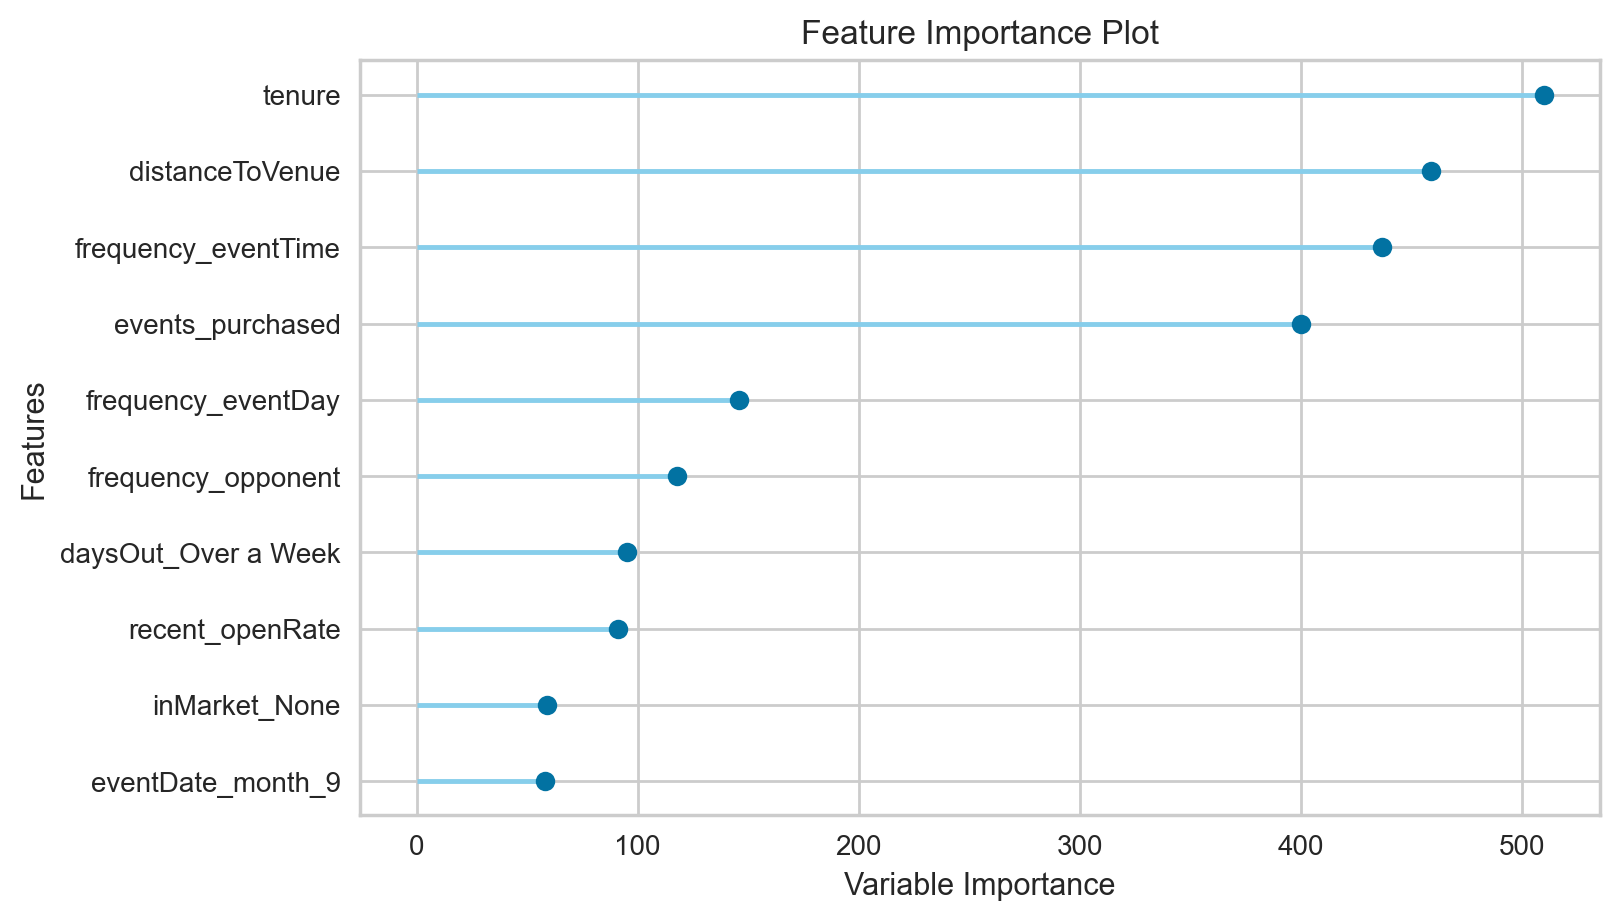

In [20]:
plot_model(final_model, plot='feature')

## Experiment : Scoring Model

### Now that we have a model, we need to get a dataset of all customers who have purchased an individual ticket for the specified team:

In [21]:
s3_resource = boto3.resource('s3')
my_bucket = s3_resource.Bucket(S3_BUCKET)

file_list = []
for object_summary in my_bucket.objects.filter(Prefix=S3_OBJECT):
        file_list.append(object_summary.key)

df_games = []
for idx, filename in enumerate(file_list):
    
    if idx > 0:

        s3_client = boto3.client("s3")
        obj = s3_client.get_object(Bucket=S3_BUCKET, Key=filename)
        df_game = pd.read_csv(obj["Body"])
        
        df_games.append(df_game)

df_inference = pd.concat(df_games)
df_inference.fillna(method="backfill", inplace=True)

df_inference.shape

(1515528, 21)

### Let's use our model to score all of the inference data to get a probability that they will purchase an individual ticket:

In [22]:
df_scores = predict_model(final_model, data=df_inference, raw_score=True)

In [23]:
df_scores.head()

,id,lkupclientid,dimcustomermasterid,customercompositekey,eventname,eventscore,daysoutbucket,date_effective_start,date_effective_end,daysOut,...,frequency_opponent,frequency_eventDay,frequency_eventTime,inMarket,distanceToVenue,recent_openRate,recent_clickRate,Label,Score_0,Score_1
0,0.0,92.0,327324.0,1.405846e+15,20220402 - Los Angeles Kings,0.9953,NaN,2022-03-31 00:00:00.000,NaN,Day Of,...,1.0,1.0,1.0,t,52.56,0.5,1.0,0,0.5858,0.4142
1,1.0,92.0,1338794.0,5.750076e+15,20220402 - Los Angeles Kings,0.9945,NaN,2022-03-31 00:00:00.000,NaN,Day Of,...,1.0,1.0,1.0,t,52.56,0.5,1.0,0,0.5858,0.4142
2,2.0,92.0,114951.0,4.937108e+14,20220402 - Los Angeles Kings,0.9914,NaN,2022-03-31 00:00:00.000,NaN,Day Of,...,1.0,1.0,1.0,t,52.56,0.5,1.0,0,0.5858,0.4142
3,3.0,92.0,283974.0,1.219659e+15,20220402 - Los Angeles Kings,0.9904,NaN,2022-03-31 00:00:00.000,NaN,Day Of,...,1.0,1.0,1.0,t,52.56,0.5,1.0,0,0.5858,0.4142
4,4.0,92.0,182504.0,7.838487e+14,20220402 - Los Angeles Kings,0.9902,NaN,2022-03-31 00:00:00.000,NaN,Day Of,...,1.0,1.0,1.0,t,52.56,0.5,1.0,0,0.5858,0.4142


### Here we can see the distribution of event propensity scores for all fans who have purchased an individual ticket previously:

NUMBER INDIVIDUAL BUYERS: 1515528


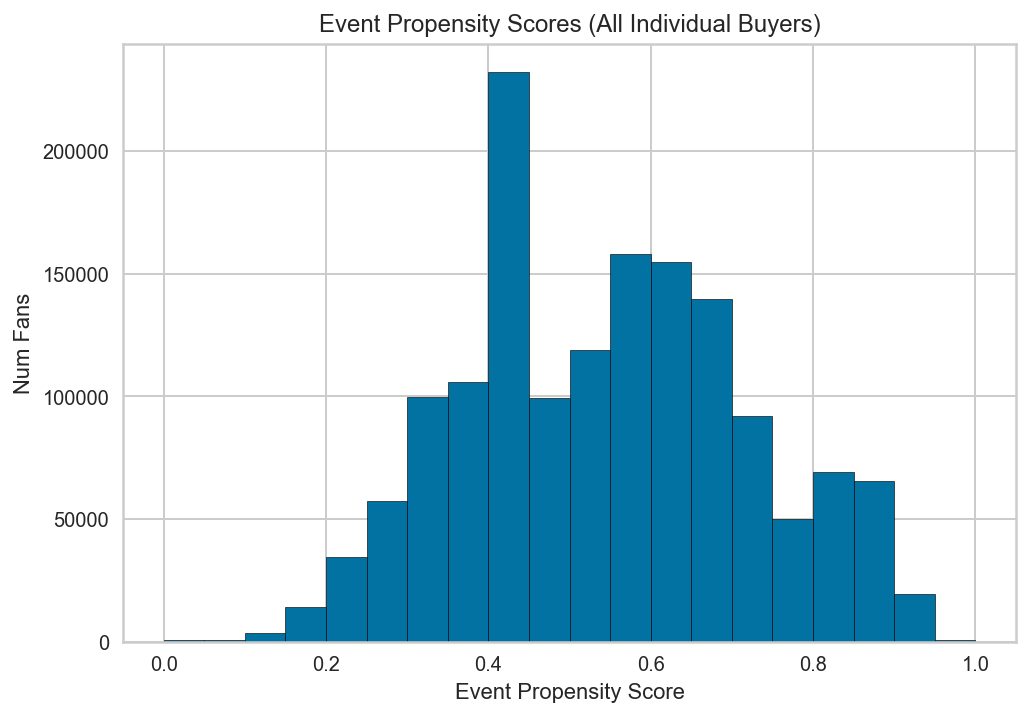

In [24]:
print(f"NUMBER INDIVIDUAL BUYERS: {len(df_scores)}")

plt.title("Event Propensity Scores (All Individual Buyers)")
plt.ylabel("Num Fans")
plt.xlabel("Event Propensity Score")
plt.hist(df_scores["Score_1"], bins=20, edgecolor="black", range=(0,1))

plt.show()

### Let's write these scoring results out to csv files based on the event date so we can upload them into the CDP lead recommender. 

### ! In the future, we could write these scores directly to the cohort event propensity table

In [25]:
dates = df_scores['eventDate'].unique()
parent_dir = "./results/"

print(f"EXPORTING {DB_NAME} EVENT PROPENSITY SCORES TO:")
for date in dates:
    
    path = parent_dir + date
    if not os.path.exists(path):
        os.makedirs(path)
        
    df_date_scores = df_scores[df_scores["eventDate"] == date]    
    df_date_scores.to_csv(f"{path}/NHL-Jets-{date}-results.csv")
    
    print(f"{path}")

EXPORTING stlrNHLJets EVENT PROPENSITY SCORES TO:
./results/2022-04-02
./results/2022-04-06
./results/2022-04-13
./results/2022-04-24
./results/2022-04-27
./results/2022-04-29
./results/2022-05-01


## Experiment: Evaluating Model

#### Let's create a baseline group of all records and call it df_baseline. We'll also select the top 10,000 records based on the highest event propensity score and store those in a dataframe called df_top_leads:

In [ ]:
num_leads = int((len(df_scores) / 5))

df_baseline = df_scores
df_top_leads = df_scores.sort_values(by=["Score_1"], ascending=False).iloc[0:num_leads]

print(f"NUMBER OF BASELINE SCORES: {len(df_baseline)}")
print(f"NUMBER OF TOP LEADS SCORES: {len(df_top_leads)}")

### Now let's create a session and connection to RedShift so we can query the purchases table:

In [ ]:
client = boto3.client('redshift')
    
conn = wr.data_api.redshift.connect(
    cluster_id = CLUSTER,
    database = DB_NAME.lower(),
    db_user = "admin"
)

print(f"CREDENTIALS RETRIEVED SUCCESSFULLY!")

### Let's get the actual ticket purchases for a specificed event, and store it in a dataframe called df_target_game:

In [ ]:
#event_name = "20220329 - Colorado Avalanche"
#event_name = "20220326 - Edmonton Oilers"
#event_name = "20220325 - Arizona Coyotes"
event_name = "20220322 - San Jose Sharks"
#event_name = "20220318 - Buffalo Sabres"


sql_statement = f"""
    SELECT *
    FROM {DB_NAME.lower()}.dw.cohortpurchase
    WHERE eventName = '{event_name}'
    AND productgrouping = '{PRODUCT}';
"""

df_target_game = wr.data_api.redshift.read_sql_query(
    sql = sql_statement, 
    con = conn
)

print(f"NUMBER {PRODUCT} TICKETS SOLD: {len(df_target_game)}")

### Let's compare our baseline & top leads dataframes  against the actuals dataframe to see if any baseline or top leads purchased tickets for the specified event:

In [ ]:
df_target_game['dimCustomerMasterId'] = df_target_game['dimcustomermasterid']

df_merged_baseline = pd.merge(df_baseline, df_target_game, on=['dimCustomerMasterId'], how='inner')
df_merged_top_leads = pd.merge(df_top_leads, df_target_game, on=['dimCustomerMasterId'], how='inner')

print(f"NUMBER MATCHED BASELINE LEADS: {len(df_merged_baseline)} / {len(df_baseline)}")
print(f"NUMBER MATCHED TOP LEADS: {len(df_merged_top_leads)} / {len(df_top_leads)}")

### Now we can calculate some conversion percentages for both the baseline dataset and our top leads dataset and see if there was an increase in conversion by using the top leads:

In [ ]:
baseline_conversion = (len(df_merged_baseline) / len(df_baseline))
top_leads_conversion = (len(df_merged_top_leads) / len(df_top_leads))

print(baseline_conversion * 100)
print(top_leads_conversion * 100)

#top_leads_increase = (top_leads_conversion / baseline_conversion)

#print(f"TOP LEADS CONVERTED AT {top_leads_increase} X")

## Observations